# gymflow


For any business, a key challenge for growth of the business depends on not only identifying leads, but identifying leads with the highest potential closing value. For small businesses, performance measures are obfuscated from the public for obvious reasons. Though performance data for private businesses are largely unavailable to the public, if we can identify a representative sample dataset for the population of interest, performance measures can be modeled from publicly available attributes, and then applied to any private business. 

The goal of this project is to build a regression model to predict number of *Yelp* check-in's for a business given pubicly availabile attributes, namely its geographical location and business category. The intent is to use Yelp "check-in's" as a proxy for foot traffic.

The project is structured in three sections:


#### 1. Data Preparation and Analysis
* **a. Data Wrangling, Munging, and Schema Assembly**
* **b. EDA**
* **c. Data Preparation and Pipeline Creation**

#### 2. Model Selection, Training, and Analysis

#### 3. Interface

#### 4. Appendix 

<br><br>
Author: Max Copeland (c) <br> Date: April 2021

In [1]:
import json
import os
from typing import List, Dict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pybea.client import BureauEconomicAnalysisClient
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.sql import SparkSession
from pyspark.sql.functions import explode, split, col, to_timestamp, count, month, year
from scipy import stats
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from yelpapi import YelpAPI


%matplotlib inline
sns.set()

In [2]:
# Instantiating spark session
spark = SparkSession.builder.getOrCreate()

# 1. Data Preparatioin and Analysis

## a. Data Wrangling, Munging, and Schema Assembly  

### Yelp Academic Dataset
Yelp published an [academic dataset](https://www.yelp.com/dataset) for any and all personal use. The aim of this project is to model check-in frequency as a function of publicly available business attributes (i.e. what is the trend of check-ins for Barre studios in Seattle?). The Check-In data will be the data workhorse, and additional dimensional data will be included for enrichment and additional feature generation.

In [3]:
# Reading yelp dataset of business listings
business_df = spark.read.option("inferSchema", "true").json("data/yelp_dataset/yelp_academic_dataset_business.json")

# Reading checkin dataset
checkin_df = spark.read.option("inferSchema", "true").json("data/yelp_dataset/yelp_academic_dataset_checkin.json")
# Splitting up "date" string field into array, delimited on commas
checkin_df = checkin_df.withColumn('date', split(col('date'), ', ').cast('array<string>'))


In [4]:
# Reading schema for the yelp business listsings
business_df.printSchema()

root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru: string (nullable = true)
 |    |-- GoodForDancing: str

In [5]:
# Reading schema for the yelp check-in data
checkin_df.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- date: array (nullable = true)
 |    |-- element: string (containsNull = true)



Creating view into spark session for downstream SQL functionality.

In [6]:
business_df.createOrReplaceTempView("businesses")
checkin_df.createOrReplaceTempView("checkins")

Filtering down `business_df` for categories pertinent to the fitness indstury.

In [7]:
gym_cond = (
            (
                business_df.categories.contains("Gym") | \
            business_df.categories.contains("Fitness") | \
            business_df.categories.contains("Wellness") | \
            business_df.categories.contains("Yoga") | \
            business_df.categories.contains("Spa") | \
            business_df.categories.contains("Sports") | \
            business_df.categories.contains("Cycling") | \
            business_df.categories.contains("Boxing") | \
            business_df.categories.contains("Recreation")    
            ) 
                  & 
            (
            ~business_df.categories.contains("Bars") & \
            ~business_df.categories.contains("Restaurant") & \
            ~business_df.categories.contains("Shopping")
            )
        
        )

gym_df = business_df.where(gym_cond)
gym_df.createOrReplaceTempView("gym_businesses")

Joining `checkin_df` against the filtered `business_df`. Resulting table will have the same number of entries as `business_df`, but with and an additional field containing an array of all checkins. 

In [8]:
gym_checkin_df = checkin_df.join(gym_df, on="business_id", how='inner')

gym_checkin_df = gym_checkin_df.withColumn('categories', split(col('categories'), ', ').astype('array<string>'))

## Exploding out checkin data to have singular category vector

To have a more trainable model downstream, it is important that I scaffold out the current dataset to contain a record for every unique pairing of category and check-in timestamp for each associated with a business. 

In this format, we can run an aggregation to bin number of check-in's by some time-interval (likely year).

In [9]:
# Reminding myself of the schema for our current dataset
gym_checkin_df.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- date: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = tru

In [11]:
# Scaffolding out check-in array field into a record for every check-in timestamp per business
checkin_df_exploded = gym_checkin_df.select("business_id", "categories", 
                                                  explode(col("date")).alias("date")).withColumn("date", to_timestamp("date"))

# Further scaffolding out categories array field into a record for every distint category per business
checkin_df_exploded = checkin_df_exploded.select("business_id", "date", explode(col("categories")).alias("category"))

In [12]:
checkin_df_exploded.show()

+--------------------+-------------------+-------------------+
|         business_id|               date|           category|
+--------------------+-------------------+-------------------+
|--8LPVSo5i0Oo61X0...|2016-07-08 16:43:30|Weight Loss Centers|
|--8LPVSo5i0Oo61X0...|2016-07-08 16:43:30|            Doctors|
|--8LPVSo5i0Oo61X0...|2016-07-08 16:43:30|    Sports Medicine|
|--8LPVSo5i0Oo61X0...|2016-07-08 16:43:30|       Orthopedists|
|--8LPVSo5i0Oo61X0...|2016-07-08 16:43:30|   Health & Medical|
|--9QQLMTbFzLJ_oT-...|2010-06-26 17:39:07|        Hair Salons|
|--9QQLMTbFzLJ_oT-...|2010-06-26 17:39:07|      Beauty & Spas|
|--9QQLMTbFzLJ_oT-...|2010-08-01 20:06:21|        Hair Salons|
|--9QQLMTbFzLJ_oT-...|2010-08-01 20:06:21|      Beauty & Spas|
|--9QQLMTbFzLJ_oT-...|2010-12-09 21:21:24|        Hair Salons|
|--9QQLMTbFzLJ_oT-...|2010-12-09 21:21:24|      Beauty & Spas|
|--9QQLMTbFzLJ_oT-...|2011-08-12 00:42:57|        Hair Salons|
|--9QQLMTbFzLJ_oT-...|2011-08-12 00:42:57|      Beauty 

In this format, we can now run an aggregation to count the number of check-in's per business per category.

In [13]:
checkin_df_yearly = checkin_df_exploded.groupBy("business_id", "category", year("date").alias("year")).count()

# Adding table to the data model
checkin_df_yearly.createOrReplaceTempView("checkin_count_yr")

Confirming SQL functionality on new table...

In [14]:
spark.sql("SELECT * FROM checkin_count_yr ORDER BY business_id, year").show()

+--------------------+-------------------+----+-----+
|         business_id|           category|year|count|
+--------------------+-------------------+----+-----+
|--8LPVSo5i0Oo61X0...|    Sports Medicine|2016|    1|
|--8LPVSo5i0Oo61X0...|Weight Loss Centers|2016|    1|
|--8LPVSo5i0Oo61X0...|            Doctors|2016|    1|
|--8LPVSo5i0Oo61X0...|       Orthopedists|2016|    1|
|--8LPVSo5i0Oo61X0...|   Health & Medical|2016|    1|
|--9QQLMTbFzLJ_oT-...|      Beauty & Spas|2010|    3|
|--9QQLMTbFzLJ_oT-...|        Hair Salons|2010|    3|
|--9QQLMTbFzLJ_oT-...|        Hair Salons|2011|    3|
|--9QQLMTbFzLJ_oT-...|      Beauty & Spas|2011|    3|
|--9QQLMTbFzLJ_oT-...|        Hair Salons|2012|    2|
|--9QQLMTbFzLJ_oT-...|      Beauty & Spas|2012|    2|
|--9QQLMTbFzLJ_oT-...|        Hair Salons|2013|    8|
|--9QQLMTbFzLJ_oT-...|      Beauty & Spas|2013|    8|
|--9QQLMTbFzLJ_oT-...|        Hair Salons|2014|    8|
|--9QQLMTbFzLJ_oT-...|      Beauty & Spas|2014|    8|
|--9QQLMTbFzLJ_oT-...|      

In [15]:
spark.sql("""
            SELECT biz.postal_code, chk.category, chk.year, chk.count
            FROM gym_businesses biz
            INNER JOIN checkin_count_yr chk
                ON biz.business_id = chk.business_id
         """
         ).show()

+-----------+--------------------+----+-----+
|postal_code|            category|year|count|
+-----------+--------------------+----+-----+
|      85283|       Beauty & Spas|2018|    3|
|      89147|        Hair Removal|2019|   25|
|      85259|            Day Spas|2015|    1|
|      85032|     Sports Medicine|2013|    6|
|      89102|         Hair Salons|2018|    4|
|      89103|           Skin Care|2017|    3|
|      85297|         Hair Salons|2019|    3|
|      61820|       Beauty & Spas|2016|    1|
|      89102|       Beauty & Spas|2014|   10|
|      89012|         Nail Salons|2015|   11|
|      15206|       Beauty & Spas|2019|    1|
|      89052|         Active Life|2018|    1|
|      89178|         Active Life|2014|   23|
|      28078|Venues & Event Sp...|2012|    5|
|    J5B 1H1|         Active Life|2017|    1|
|      85282|    Health & Medical|2014|    2|
|      89117|         Nail Salons|2018|   20|
|    L5N 2W7|                Gyms|2013|    5|
|    T2S 0A5|     Eyelash Service|

### Parsing City Data

There are two datasets of interest for regional data: one with information on all US cities, and a dataset of population estimates for each US county from 2010-2019. 

In [16]:
CITIES_FILEPATH = os.path.join("data", "uscities.csv")
COUNTY_POPULATIONS_FILEPATH = os.path.join("data", "co-est2019-alldata.csv")


First, I need to write a function to read the files and merge them.

In [17]:
def get_cities_df(cities_filepath, population_filepath, limit=None):
    """
    
    Returns dataframe of city-level attributes for all US cities. 
    
    
    input
    -----
    cities_filepath, str
        relative or absolute filepath to uscities.csv
    
    population_filepath, str
        relative or absolute filepath to co-est2019-alldata.csv
        
        
    output
    -----
    pandas Dataframe
    
    """
    city_df = pd.read_csv(cities_filepath).sort_values("population", ascending=False)
    city_df['city_st'] = city_df['city_ascii'] + ", " + city_df['state_id']

    if limit is not None:
        city_df = city_df.iloc[:limit, :]
        
    pop_df = pd.read_csv(population_filepath)
    
    pop_df = pop_df[pop_df['CTYNAME'].str.contains('County')]
    pop_df['CTYNAME'] = pop_df['CTYNAME'].apply(lambda x: x.split(' County')[0])
    
    full_df = pd.merge(city_df, pop_df, left_on=['county_name', 'state_name'], 
                       right_on=['CTYNAME', 'STNAME'])
    
    return full_df.reset_index()

    


Reading in datafiles...

In [18]:
cities_pd_df = get_cities_df(CITIES_FILEPATH, COUNTY_POPULATIONS_FILEPATH)

In [19]:
cities_pd_df.head()

,index,city,city_ascii,state_id,state_name,county_fips,county_name,lat,lng,population,...,RDOMESTICMIG2019,RNETMIG2011,RNETMIG2012,RNETMIG2013,RNETMIG2014,RNETMIG2015,RNETMIG2016,RNETMIG2017,RNETMIG2018,RNETMIG2019
0,0,New York,New York,NY,New York,36061,New York,40.6943,-73.9249,18713220,...,-7.201265,6.150025,3.585789,-3.412067,-3.133048,-1.605270,-4.965909,-7.488348,-4.535926,-3.071435
1,1,Manhattan,Manhattan,NY,New York,36061,New York,40.7834,-73.9662,1628706,...,-7.201265,6.150025,3.585789,-3.412067,-3.133048,-1.605270,-4.965909,-7.488348,-4.535926,-3.071435
2,2,Los Angeles,Los Angeles,CA,California,6037,Los Angeles,34.1139,-118.4068,12750807,...,-10.024157,-2.160639,-1.102370,-1.268074,-2.306246,-2.202978,-3.985415,-5.864988,-7.670182,-7.930985
3,3,Long Beach,Long Beach,CA,California,6037,Los Angeles,33.7981,-118.1675,462628,...,-10.024157,-2.160639,-1.102370,-1.268074,-2.306246,-2.202978,-3.985415,-5.864988,-7.670182,-7.930985
4,4,Lancaster,Lancaster,CA,California,6037,Los Angeles,34.6935,-118.1753,343304,...,-10.024157,-2.160639,-1.102370,-1.268074,-2.306246,-2.202978,-3.985415,-5.864988,-7.670182,-7.930985


Unfortunately, the county population data format won't be usable for training. These attributes are housed in separate fields for each year they were recorded. The format we need needs to have single field for the metric, and be broken out by the year of recording.

In [20]:
# These are the prefixes of interest from the county data 
feats = ['POPESTIMATE',
 'NPOPCHG_',
 'BIRTHS',
 'DEATHS',
]

# By convention, the city data has lower-case fieldnames by design, and 
# county data has upper-case fieldnames by design. Thus I can run a boolean index
# based on case to delineate dimensions and measures.
dimensions = cities_pd_df.columns[~cities_pd_df.columns.str.isupper()]
measures = cities_pd_df.columns[cities_pd_df.columns.str.isupper()]

The below functions reformat the county population data such that each population measure is broken out by year.

In [21]:
def get_cols(df, prefix):
    """
    
    Runs a search on column names based on given prefix and returns a list of matches
    
    
    input
    -----
    df, pandas Dataframe object
    
    prefix, str
        Prefix to be searched
    
    
    output
    -----
    list of columns with matching prefix
        
    """
    return list(df.columns[[(prefix == x[:-4]) for x in df.columns]].values)


def format_cities_df(df, feats):
    """
    
    Reformats county data to contain a field for each type of measure, 
    broken out by year. 
    
    
    input
    -----
    df, pandas Dataframe object
    
    feats, list
        Column names to be broken out
    
    
    output
    -----
    pandas Dataframe
    
    """
    
    full_df = None
    
    for feat in feats:
        
        # Get the columns that have the given prefix 
        cols = get_cols(df, feat)
        
        # Getting identifier dimensions plus the retrieved columns for the measure of interest
        data = df[['city', 'state_name', 'zips', 'lat', 'lng'] + cols]
        
        # Breaking out down to have a single column for the measure, with a record 
        # for each year it was recorded
        melted = pd.melt(data, id_vars=['city', 'state_name', 'zips', 'lat', 'lng'], 
                         value_vars=cols, value_name=feat, var_name='year')
        
        # Parsing the year from the feature name
        melted['year'] = melted['year'].apply(lambda x:x[-4:])

        # Iteratively merging data for each feature into a single dataframe
        if full_df is None:
            full_df = melted
        
        else:
            full_df = pd.merge(full_df, melted, how='left', left_on=['city', 'state_name', 'year', 'zips', 'lat', 'lng'], 
                               right_on=['city', 'state_name', 'year', 'zips', 'lat', 'lng'])

    
    return full_df

In [22]:
cities_pd_df.head()

,index,city,city_ascii,state_id,state_name,county_fips,county_name,lat,lng,population,...,RDOMESTICMIG2019,RNETMIG2011,RNETMIG2012,RNETMIG2013,RNETMIG2014,RNETMIG2015,RNETMIG2016,RNETMIG2017,RNETMIG2018,RNETMIG2019
0,0,New York,New York,NY,New York,36061,New York,40.6943,-73.9249,18713220,...,-7.201265,6.150025,3.585789,-3.412067,-3.133048,-1.605270,-4.965909,-7.488348,-4.535926,-3.071435
1,1,Manhattan,Manhattan,NY,New York,36061,New York,40.7834,-73.9662,1628706,...,-7.201265,6.150025,3.585789,-3.412067,-3.133048,-1.605270,-4.965909,-7.488348,-4.535926,-3.071435
2,2,Los Angeles,Los Angeles,CA,California,6037,Los Angeles,34.1139,-118.4068,12750807,...,-10.024157,-2.160639,-1.102370,-1.268074,-2.306246,-2.202978,-3.985415,-5.864988,-7.670182,-7.930985
3,3,Long Beach,Long Beach,CA,California,6037,Los Angeles,33.7981,-118.1675,462628,...,-10.024157,-2.160639,-1.102370,-1.268074,-2.306246,-2.202978,-3.985415,-5.864988,-7.670182,-7.930985
4,4,Lancaster,Lancaster,CA,California,6037,Los Angeles,34.6935,-118.1753,343304,...,-10.024157,-2.160639,-1.102370,-1.268074,-2.306246,-2.202978,-3.985415,-5.864988,-7.670182,-7.930985


Reformatting data with above function...

In [23]:
formatted_cities_df_pd = format_cities_df(cities_pd_df, feats)
formatted_cities_df_pd.head()

,city,state_name,zips,lat,lng,year,POPESTIMATE,NPOPCHG_,BIRTHS,DEATHS
0,New York,New York,11229 11226 11225 11224 11222 11221 11220 1138...,40.6943,-73.9249,2010,1588767,2386,5028,2290
1,Manhattan,New York,10026 10027 10030 10037 10039 10001 10011 1001...,40.7834,-73.9662,2010,1588767,2386,5028,2290
2,Los Angeles,California,90291 90293 90292 91316 91311 90037 90031 9000...,34.1139,-118.4068,2010,9823246,3278,31738,13803
3,Long Beach,California,90822 90804 90805 90806 90807 90802 90803 9080...,33.7981,-118.1675,2010,9823246,3278,31738,13803
4,Lancaster,California,93535 93534 93536 93539 93584,34.6935,-118.1753,2010,9823246,3278,31738,13803


Converting output data into spark dataframe for integration with our data model.

In [24]:
formatted_cities_df = spark.createDataFrame(formatted_cities_df_pd)

# Scaffolding out zip code array to have a record for each distinct zip. 
# This is important as the zip code will be our key with which we we'll run 
# downstream joins.
formatted_cities_df = formatted_cities_df.withColumn("zip", explode(split(col("zips"), "\s+")))

In [25]:
# Adding reformatted data as a table in our data model.
formatted_cities_df.createOrReplaceTempView("populations")

In [26]:
spark.sql("SHOW tables").show()

+--------+----------------+-----------+
|database|       tableName|isTemporary|
+--------+----------------+-----------+
|        |      businesses|       true|
|        |checkin_count_yr|       true|
|        |        checkins|       true|
|        |  gym_businesses|       true|
|        |     populations|       true|
+--------+----------------+-----------+



In [28]:
df_spark = spark.sql("""
                            SELECT biz.latitude, biz.longitude, biz.stars, biz.review_count, pop.POPESTIMATE as population,
                                    chk.category, chk.year, chk.count as label
                            FROM checkin_count_yr chk
                            LEFT JOIN gym_businesses biz
                                ON chk.business_id = biz.business_id
                            LEFT JOIN populations pop
                                 ON biz.postal_code = pop.zip AND chk.year = pop.year
                            WHERE pop.POPESTIMATE IS NOT NULL
                          """)

In [29]:
df_spark.show()

+-------------+--------------+-----+------------+----------+--------------------+----+-----+
|     latitude|     longitude|stars|review_count|population|            category|year|label|
+-------------+--------------+-----+------------+----------+--------------------+----+-----+
|   40.4275224|   -79.9679844|  3.5|          26|   1233027|        Hair Removal|2014|    1|
|   40.4275224|   -79.9679844|  3.5|          26|   1233027|       Beauty & Spas|2014|    1|
|   40.4275224|   -79.9679844|  3.5|          26|   1233027|    Ophthalmologists|2014|    1|
|   40.4275224|   -79.9679844|  3.5|          26|   1233027|   Cosmetic Surgeons|2014|    1|
|   40.4275224|   -79.9679844|  3.5|          26|   1233027|  Laser Hair Removal|2014|    1|
|   40.4275224|   -79.9679844|  3.5|          26|   1233027|             Doctors|2014|    1|
|   40.4275224|   -79.9679844|  3.5|          26|   1233027|        Optometrists|2014|    1|
|   40.4275224|   -79.9679844|  3.5|          26|   1233027|    Health

## b. EDA

Here I'll explore the distributions and correlations between variables, as well as identify any problematic outliers.

In [30]:
df = df_spark.toPandas()

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450550 entries, 0 to 450549
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   latitude      450550 non-null  float64
 1   longitude     450550 non-null  float64
 2   stars         450550 non-null  float64
 3   review_count  450550 non-null  int64  
 4   population    450550 non-null  int64  
 5   category      450550 non-null  object 
 6   year          450550 non-null  int32  
 7   label         450550 non-null  int64  
dtypes: float64(3), int32(1), int64(3), object(1)
memory usage: 25.8+ MB


Luckily no nulls in our data, which was by design in our data model construction.

In [32]:
df.describe()

,latitude,longitude,stars,review_count,population,year,label
count,450550.000000,450550.000000,450550.000000,450550.000000,4.505500e+05,450550.000000,450550.000000
mean,36.250443,-103.254031,3.963689,48.006681,2.434779e+06,2015.346372,23.885484
std,2.961348,14.912698,0.811950,102.377777,1.420107e+06,2.556731,101.153244
min,33.215156,-115.366722,1.000000,3.000000,1.850000e+04,2010.000000,1.000000
25%,33.587957,-115.117904,3.500000,9.000000,1.233700e+06,2013.000000,2.000000
50%,36.033257,-111.931770,4.000000,22.000000,2.138836e+06,2016.000000,4.000000
75%,36.215546,-81.658105,4.500000,51.000000,4.093648e+06,2018.000000,13.000000
max,43.250923,-79.651157,5.000000,2746.000000,1.010371e+07,2019.000000,3918.000000


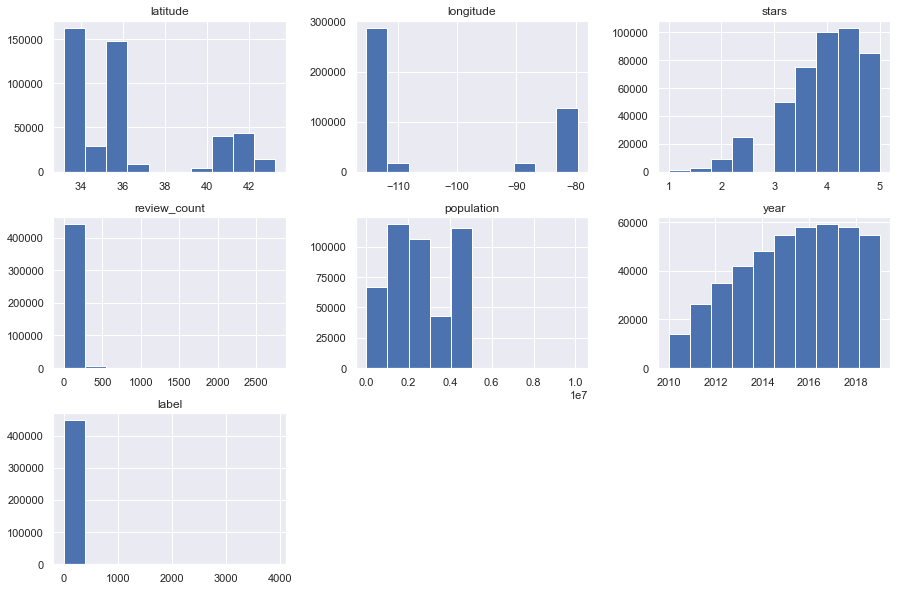

In [33]:
df.hist(figsize=(15, 10));

Creating correlation matrix to identifying covarying features.

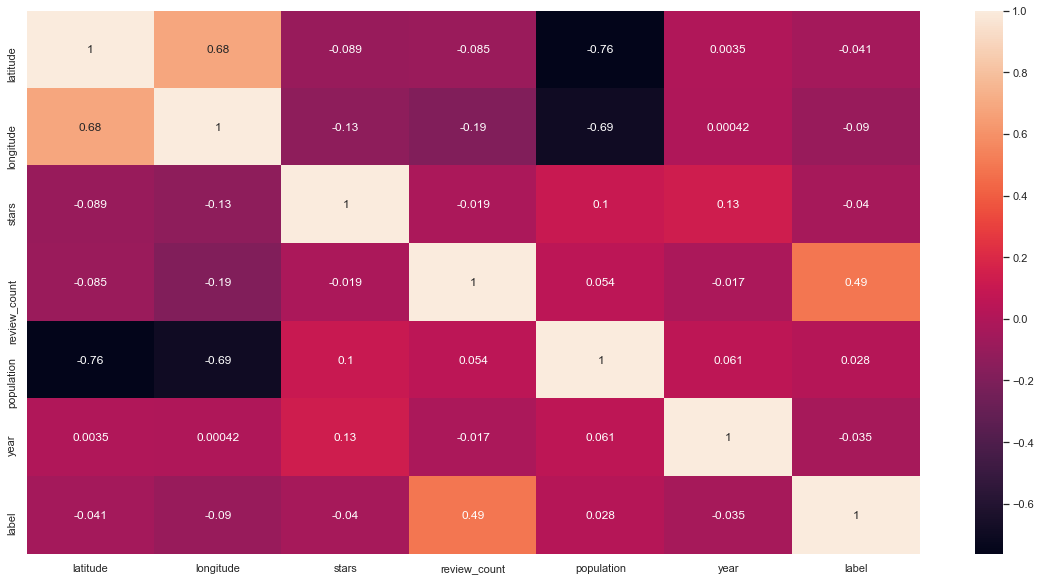

In [34]:
corr_mat = df.corr(method='pearson')
plt.figure(figsize=(20, 10))
sns.heatmap(corr_mat, annot=True);

An interesting covariance is between population and longitude/latitude. Similarly a positive correlation with longitude and latitude. 

In [35]:
# List comprehension to get all categories and their counts
category_counts = df.category.value_counts()

Analyzing highest checked-in business categories and their distributions...

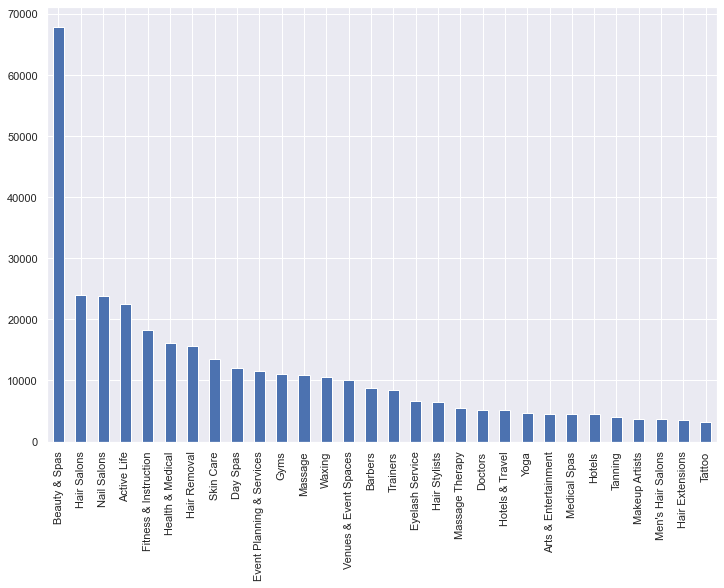

In [36]:
fig, ax = plt.subplots(figsize=(12, 8))

category_counts[:30].plot(kind='bar', ax=ax);

Here, we have a set of businesses has an associated set of categories. For the purposes of this analysis, we are not interested in business-level data, nor are we are interested in category-set-level data-- we are interested in data at the singular-category level. 

To achieve this, we must aggregate and union checkins across businesses.

In [37]:
gym_checkin_pd_df = gym_checkin_df.select("categories", "date").toPandas()

In [38]:
target_categories = category_counts.index.values[:30]

# Dict where k:v is <category>:<checkin_array>
checkins = {cat:[] for cat in target_categories}

# Loop through list of lists, and extend checkin array in the checkins dict
for cat_list, checkin_array in zip(gym_checkin_pd_df.categories, gym_checkin_pd_df.date):
    for cat in cat_list:
        if cat in target_categories:
            checkins[cat].extend(checkin_array)

In [39]:
# Casting arrays to datetime objects
for cat, checkin_arr in checkins.items():
    checkins[cat] = pd.to_datetime(checkin_arr).sort_values()


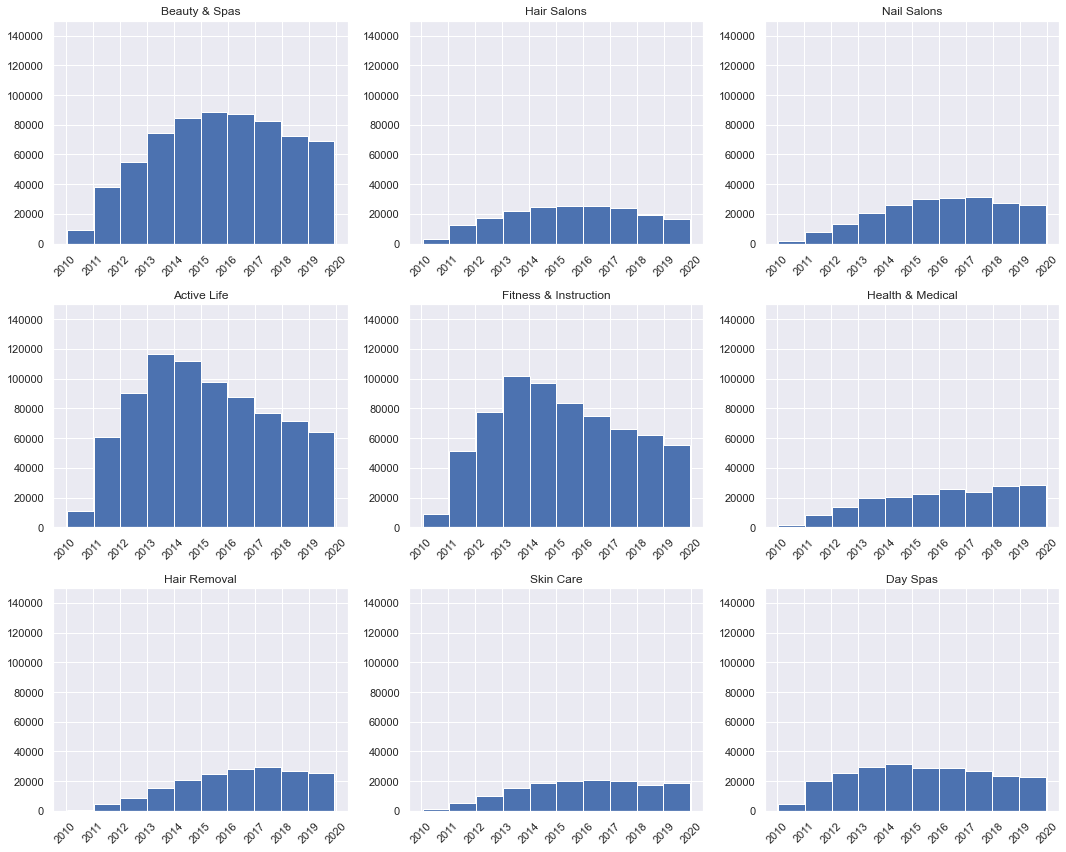

In [40]:
# Building out charts on handful of categories validate the upstream checkin aggregation

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(15, 12))


axes = (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9)


for ax, cat in zip(axes, category_counts.index.values[:len(axes)]):
    ax.hist(checkins[cat])
    ax.set_title(cat)
    ax.tick_params(axis='x', labelrotation=45)
    ax.set_ylim((0, 150000))

plt.tight_layout()


Generating a Cumulative Distribution Function of our category frequencies. For training, it makes sense to limit the number of categories to those with a higher volume of data points.

In [41]:
# Getting ordered bins of frequency
freq = df['category'].value_counts().values

# Calculating cdf
cdf = np.cumsum(freq) / np.sum(freq)

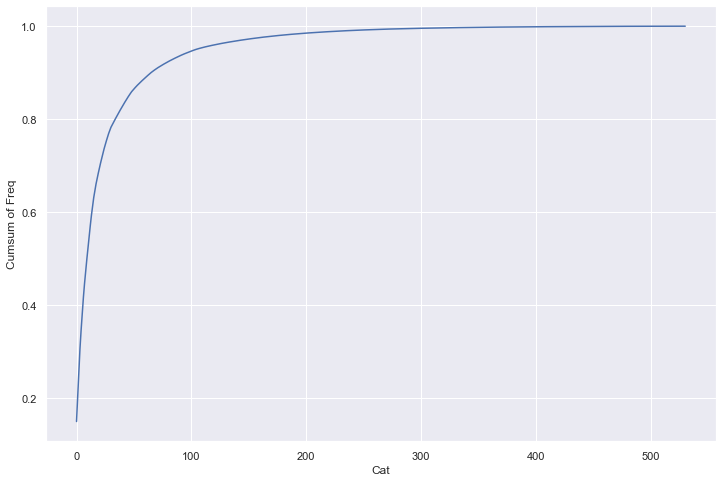

In [42]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(cdf)
ax.set_ylabel('Cumsum of Freq')
ax.set_xlabel('Cat');

## c. Data Prep

I plan to use a tree-based model, which helps us avoid the scaling/encoding steps necessary for linear models.

One necessary preprocessing step is to create a custom encoding of categories, as tree models require a numeric value.  Rather than using ordinal encoding, I'll make this encoded value to be a function of the number of occurrences in the training data. To avoid collisions, I will add a high precision randomly generated number on (0, 1). 

In [43]:
def encode_categories(categories_col, return_map=False):
    """
    
    Numerically encode business categories as a function of frequency.
    
    input
    -----
    categories_col, pandas Series
        List of all categories to be encoded
    return_map, bool
        Optional, if true, return the mapping dictionary for encoding
        
    
    output
    -----
    pandas Series
    
    """
    
    cat_counts = categories_col.value_counts()
    
    encoding_map = {k:v + np.random.random() for k, v in zip(cat_counts.index, cat_counts.values)}
    
    if return_map:
        return categories_col.map(encoding_map), encoding_map
    
    return categories_col.map(encoding_map)

In [42]:
prep_df = df.copy()
prep_df['category'], encoding_map  = encode_categories(prep_df['category'], return_map=True)

Now we'll split up training and test data for model training and evaluation.

In [43]:
labels = prep_df['label']
prep_df = prep_df.drop(columns=['label'])
X_train, X_test, y_train, y_test = train_test_split(prep_df, labels)

# Model Training

Based on non-linearity of our encoded category variable, Random Forest is an obvious first-choice for a regressor. 
The features we will train on will be `latitude`, `longitude`, `review_count`, `stars`, `population`, and `category`. 

Note: Being that this project is being run locally, I will train the regressor strictly in sklearn, rather than spark, to avoid configuration of memory allocation to local workers. In a production environment (via EMR or the like) Spark would be the ideal framework.

From here we're at a good place to begin training. Rather than splitting up training and test data, I'll run a cross-validator on a grid of hyperparameters to find best estimator.

In [44]:
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6]},
  ]

rf_reg = RandomForestRegressor()

param_search = GridSearchCV(rf_reg, param_grid, cv=5, scoring='neg_mean_squared_error',
                           return_train_score=True)
param_search.fit(prep_df, labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6],
                          'n_estimators': [3, 10, 30]}],
             return_train_score=True, scoring='neg_mean_squared_error')

Analying mean score per param config.

In [45]:
crossval_res = param_search.cv_results_
for avg_score, params in zip(crossval_res["mean_test_score"], crossval_res["params"]):
    print(np.sqrt(-avg_score), params)

57.97187074330318 {'max_features': 2, 'n_estimators': 3}
49.76506850879349 {'max_features': 2, 'n_estimators': 10}
47.93762963384282 {'max_features': 2, 'n_estimators': 30}
55.35782038598057 {'max_features': 4, 'n_estimators': 3}
51.119694974285544 {'max_features': 4, 'n_estimators': 10}
49.027651591740856 {'max_features': 4, 'n_estimators': 30}
56.62128230944813 {'max_features': 6, 'n_estimators': 3}
51.913550296066624 {'max_features': 6, 'n_estimators': 10}
51.666374434015545 {'max_features': 6, 'n_estimators': 30}


In [46]:
param_search.best_estimator_

RandomForestRegressor(max_features=2, n_estimators=30)

In [47]:
param_search.best_params_

{'max_features': 2, 'n_estimators': 30}

Training model with best params.

In [48]:
final_reg = RandomForestRegressor(max_features=4, n_estimators=30)

final_reg.fit(X_train, y_train)

RandomForestRegressor(max_features=4, n_estimators=30)

In [49]:
y_pred = final_reg.predict(X_test)
final_rmse = np.sqrt(mean_squared_error(y_pred, y_test))

Analyzing 95% confidence interval for RMSE

In [50]:
from scipy import stats
 
conf = 0.95

squared_e = (y_pred - y_test) ** 2
conf_int_95 = np.sqrt(stats.t.interval(conf, len(squared_e) - 1, loc=squared_e.mean(), 
                                       scale=stats.sem(squared_e)))

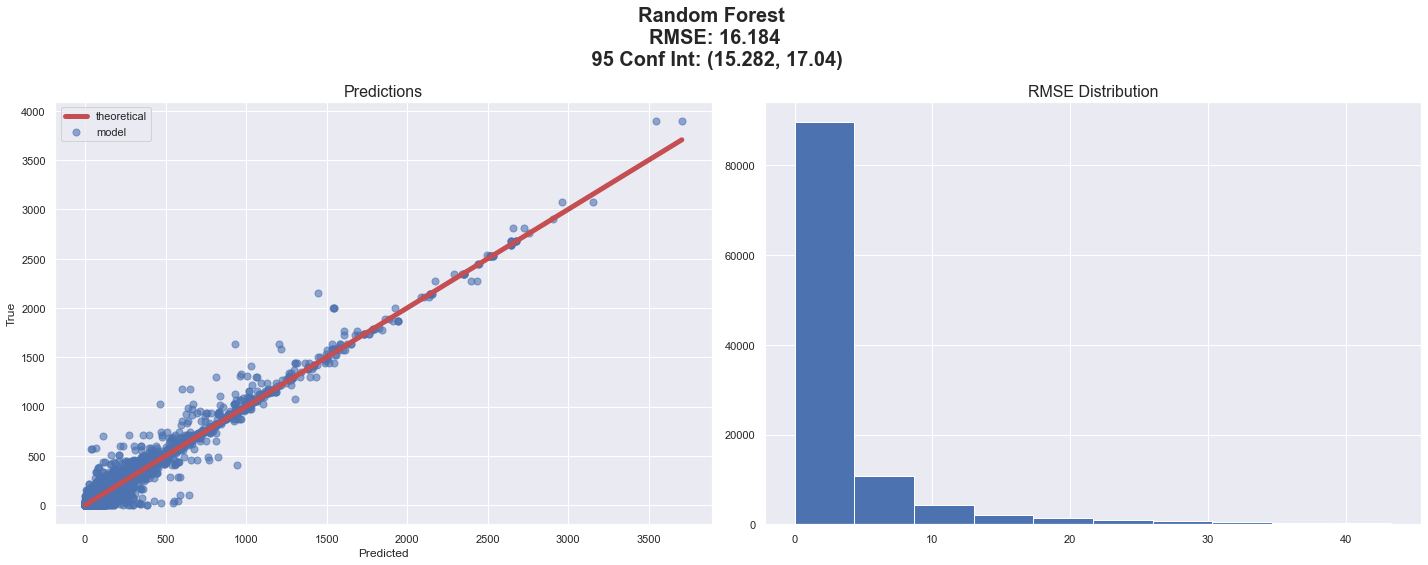

In [51]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

x = np.arange(y_pred.max())

ax[0].scatter(y_pred, y_test, alpha=0.6, s=50, label="model")
ax[0].plot(x, x, lw=5, color='r', label='theoretical')
ax[0].set_xlabel("Predicted")
ax[0].set_ylabel("True")
ax[0].set_title("Predictions", size=16)
ax[0].legend()


rmse = np.sqrt(squared_e)
z_rmse = stats.zscore(rmse)

ax[1].hist(rmse[z_rmse < 2.5])
ax[1].set_title("RMSE Distribution", size=16)


plt.suptitle(f"Random Forest \nRMSE: {round(final_rmse,3)}\n 95 Conf Int: {round(conf_int_95[0], 3), round(conf_int_95[1], 2)}", 
          size=20, weight='bold')
plt.tight_layout();

This is a good first-pass for this model. Given that the predicted value is serving as a proxy to actualy footcount, an RMSE on the order of 10 is plenty acceptable for the purposes of the project.

In [52]:
cv_results_df = pd.DataFrame(param_search.cv_results_)
cv_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.974268,0.055019,0.054667,0.004272,2,3,"{'max_features': 2, 'n_estimators': 3}",-3437.827818,-3279.998103,-3157.701189,...,-3360.737797,964.168876,9,-134.055482,-184.961728,-147.099217,-127.594964,-144.615327,-147.665344,19.943379
1,3.340509,0.115650,0.195051,0.014043,2,10,"{'max_features': 2, 'n_estimators': 10}",-2536.223701,-2345.664967,-1891.562193,...,-2476.562044,808.219991,3,-64.960219,-78.143508,-63.793410,-58.738083,-71.997904,-67.526625,6.789291
2,9.616856,0.267768,0.546123,0.008460,2,30,"{'max_features': 2, 'n_estimators': 30}",-2569.497261,-2353.087982,-1610.008632,...,-2298.016335,759.990130,1,-36.650429,-43.533328,-36.285198,-41.533076,-41.253492,-39.851105,2.874526
3,1.741654,0.122842,0.059658,0.003053,4,3,"{'max_features': 4, 'n_estimators': 3}",-3793.012876,-2822.597664,-2153.508304,...,-3064.488278,952.942877,7,-86.867534,-112.792966,-89.162443,-77.599286,-119.196118,-97.123669,16.015560
4,6.110213,0.392102,0.196877,0.008033,4,10,"{'max_features': 4, 'n_estimators': 10}",-3108.794765,-2061.155671,-1806.069240,...,-2613.223214,1018.247587,4,-47.206303,-52.146656,-49.491350,-43.439862,-58.882431,-50.233320,5.183288
5,16.832340,0.622470,0.561590,0.016856,4,30,"{'max_features': 4, 'n_estimators': 30}",-2930.733592,-2046.080582,-1605.647834,...,-2403.710621,856.916660,2,-25.543249,-29.626782,-30.936115,-29.797997,-34.448728,-30.070574,2.852554
6,2.648589,0.134832,0.062963,0.004443,6,3,"{'max_features': 6, 'n_estimators': 3}",-3797.592881,-2816.598692,-2118.296639,...,-3205.969610,799.415960,8,-104.712256,-127.128239,-137.834059,-108.288687,-117.602367,-119.113121,12.178270
7,8.805681,0.254443,0.202207,0.007969,6,10,"{'max_features': 6, 'n_estimators': 10}",-3136.020344,-2260.430255,-1977.159434,...,-2695.016704,900.262950,6,-46.026061,-66.796349,-53.522853,-52.394248,-56.518395,-55.051581,6.796316
8,25.631635,0.857945,0.598920,0.010990,6,30,"{'max_features': 6, 'n_estimators': 30}",-3032.258652,-2303.408079,-1803.197392,...,-2669.414247,878.263810,5,-32.252030,-37.736459,-36.332106,-36.675169,-44.668600,-37.532873,4.025539


In [53]:
feature_importances = param_search.best_estimator_.feature_importances_

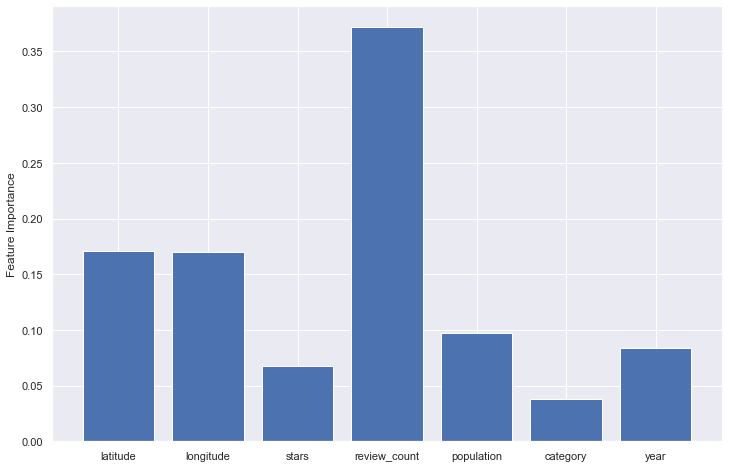

In [54]:
fig, ax = plt.subplots(figsize=(12, 8)) 


x = np.arange(len(prep_df.columns))
ax.bar(x, feature_importances)
ax.set_xticks(x)
ax.set_xticklabels(prep_df.columns);

ax.set_ylabel('Feature Importance');

Obviously the biggest surprise is how little importance category plays in the scheme of the model-- as I was expecting this to be a strong driver. As I think through the nature of the data, this actually makes sense:
* It makes sense that location would be of greater importance to the model than business category. e.g. an obscure business in downtown LA will likely have more yelp checkin's than a Starbucks in, say, Laurel MT. A way to combat this would be to make the checkin_count target variable to be computed as a function of population, which is data we have at our disposal. 
* It also makes sense that review_count would have the highest model importance. In retrospect, I should've expected this to be the field that covaries best with checkin_count. If a user is going to checkin to a business on Yelp, I would assume they are significantly more likely to leave a review while they're in the app.

## 4. Interface 

Now that the model is trainined, I'll create an interface for it. Through this custom object, we will make requests to the Yelp API and feed them to our model to get a "hot sheet" of top leads for a given location, as well at contact information.

In [55]:
with open('secrets.json') as fh:
    keys = json.load(fh)
    yelp_api_keys = keys['yelp_api']
    bea_api_keys = keys['bea_api']

In [56]:
class GymFlow:
    
    
    def __init__(self, api_key, spark_sess, model, category_encoding):
        self.api_key = api_key
        self.spark_sess = spark_sess
        self.model = model
        self.category_encoding = category_encoding
    
    
    def _get_business_data(self, search_term, location, limit=50):
        """
        Returns dataframe of business-level attributes given a search term
        and location.

        Use requires developer authentication token, see link below.
            https://www.yelp.com/login?return_url=%2Fdevelopers%2Fv3%2Fmanage_app


        example
        -----

        df = get_business_data(<API_KEY>, search_term = "brewery",
                               location = 'Seattle, WA')


        input
        -----
        api_key: str, 128-char API key provided by yelp

        search_term: str, term by which to query yelp API 
                         e.g. "gym", "brewery"

        location: str, or list of str, location by which to filter the search term, 
                       formatted <City, ST>
                       e.g. "Seattle, WA" or ["Seattle, WA", "Tacoma, WA"]

        limit: int (optional), maximum number of records to be retrieved from query
                               (cannot exceed 50)


        output
        -----
        pandas Dataframe

        """

        yelp_api = YelpAPI(self.api_key)

        if type(location) == str:
            location = [location]

        business_df = pd.DataFrame()

        for loc in location:

            try:
                response = yelp_api.search_query(term=search_term, 
                                                 location=loc,
                                                 limit=limit)

                df = pd.DataFrame(response['businesses'])

                business_df = business_df.append(df, ignore_index=True)

            except:
                break

        return self._reformat_yelp_df(business_df)

    
    def _reformat_yelp_df(self, df):
        """


        Reformats output from `get_business_data` suitable for training.


        input
        -----
        df, pandas Dataframe object

        output
        ------
        pandas Dataframe object
        """
        try: 
            coords = pd.DataFrame(df['coordinates'].values.tolist())
        except:
            return df

        df['longitude'] = coords['longitude']
        df['latitude'] = coords['latitude']
        df['zip_code'] = pd.DataFrame(df['location'].values.tolist())['zip_code']

        return df.rename(columns={"rating":"stars"})
        
        
    def get_leads(self, search_term, location, pop_estimate, year=2021):
        
        """
        
        Get list of top businesses predicted to have the most foot-traffic 
        in the given year, along with contact information.
        
        input
        -----
        search_term: str
            Business type of interest (e.g. "Gyms", "Fitness")
        
        location: str
            Name of US city or town (e.g. "Los Angeles")
        
        pop_estimate: int
            Estimated population of location for the given year
        
        year: int
            Year of interest
        
        """
        
        df = self._get_business_data(search_term, location)
        
        df['year'] = [year] * len(df)

        cat_encoded = self.category_encoding[search_term]
        df['category'] = [cat_encoded] * len(df)
        df['population'] = [int(pop_estimate)] * len(df)
        
        business_data = df[['id', 'alias', 'name', 'image_url', 'url', 'phone', 'display_phone']].copy()
        
        measures = df[['latitude', 'longitude', 'stars', 'review_count', 
                   'population','category', 'year']]
        
        y_pred = self.model.predict(measures)
        
        business_data['predicted_checkins'] = y_pred
        
        return business_data.sort_values("predicted_checkins", ascending=False)

In [57]:
gf = GymFlow(yelp_api_keys['api_key'], spark, final_reg, encoding_map)
gf.get_leads("Gyms", "Los Angeles", 2021, 3290000).head(10)

,id,alias,name,image_url,url,phone,display_phone,predicted_checkins
30,ZmqO9psJ9c11PmLzcL6I_Q,golds-gym-los-angeles-8,Gold's Gym,https://s3-media2.fl.yelpcdn.com/bphoto/a2PvG8...,https://www.yelp.com/biz/golds-gym-los-angeles...,+12136881441,(213) 688-1441,1013.400000
9,dWX_6ciOtIQBJm6WRoBHBg,la-fitness-los-angeles-11,LA Fitness,https://s3-media1.fl.yelpcdn.com/bphoto/1GgWi8...,https://www.yelp.com/biz/la-fitness-los-angele...,+13234610227,(323) 461-0227,939.933333
24,z76YG0EledyS0-DoP4wD5Q,la-fitness-los-angeles-15,LA Fitness,https://s3-media2.fl.yelpcdn.com/bphoto/8Gh5YT...,https://www.yelp.com/biz/la-fitness-los-angele...,+13234625199,(323) 462-5199,927.300000
1,-eo46Y87yj81yuO065oG8g,golds-gym-hollywood-4,Gold's Gym,https://s3-media4.fl.yelpcdn.com/bphoto/ckjxYH...,https://www.yelp.com/biz/golds-gym-hollywood-4...,+13234627012,(323) 462-7012,919.800000
19,zb3IKmIEIaBqMevAiP3o_g,24-hour-fitness-mid-wilshire-los-angeles,24 Hour Fitness - Mid Wilshire,https://s3-media4.fl.yelpcdn.com/bphoto/B9Wrps...,https://www.yelp.com/biz/24-hour-fitness-mid-w...,+12133882700,(213) 388-2700,915.466667
13,F1JrQ4EzLf_DFfmlzqFSxg,crunch-fitness-sunset-los-angeles-2,Crunch Fitness - Sunset,https://s3-media2.fl.yelpcdn.com/bphoto/xMbcKO...,https://www.yelp.com/biz/crunch-fitness-sunset...,+13236544550,(323) 654-4550,891.233333
37,8r973g-Y27grxS9JnHXzlA,crunch-fitness-burbank-burbank-2,Crunch Fitness - Burbank,https://s3-media4.fl.yelpcdn.com/bphoto/FT56Kt...,https://www.yelp.com/biz/crunch-fitness-burban...,+18183369300,(818) 336-9300,815.666667
18,ICtnatCbeDseRLMbA_x8IQ,planet-fitness-los-angeles-9,Planet Fitness,https://s3-media2.fl.yelpcdn.com/bphoto/47UUhx...,https://www.yelp.com/biz/planet-fitness-los-an...,+13239333333,(323) 933-3333,448.166667
45,lQE2WkPieSP6_4EMamvCYg,equinox-downtown-la-los-angeles-4,Equinox Downtown LA,https://s3-media2.fl.yelpcdn.com/bphoto/N1m4BR...,https://www.yelp.com/biz/equinox-downtown-la-l...,+12133303999,(213) 330-3999,433.000000
31,mELv1mjoRERLLzns6XE01A,los-angeles-athletic-club-los-angeles,Los Angeles Athletic Club,https://s3-media2.fl.yelpcdn.com/bphoto/XULrBb...,https://www.yelp.com/biz/los-angeles-athletic-...,+12136252211,(213) 625-2211,343.333333


Voila. A list of top 10 leads for gyms in Los Angeles. Qualititatively this looks like a realistic list. The top businesses returned are very recognizable chains with large footprint, so a high number of check-in's would be expected.

# Appendix 

This is a good start for a proof-of-concept. There's a few considerations for further iterations and future state:
1. Current interface requires a population estimate from user input, as our population table only contains recorded populations, not projections. Adding population projections into our data model will help us pull this from source instead of requiring it as input.

2. One area of EDA I neglected was analysis of distribution of regions. Though we looked at distribution of longitude and latitude, this wouldn't necessarily give us a good picture of how regions are sampled in the source data. Further analysis would be to bin locations by general region to assess geographical sampling. (`pygeohash` would be a useful package for this exercise.)

3. Since we have zip codes in our aggregated training data, it would be interesting to experiment with other location data. An idea I've been exploring is calling out to the Bureau of Economic Analysis API to gather economic data for each check-in location. Below is a wrapper calling get requests from the API to get regional economic data.

## Get BEA Data

In [58]:
class BEAClient(BureauEconomicAnalysisClient):
    """
    The `pybea`package lacks a few `get` methods for specific datasets useful for this project. 
    The below wrapper class inherits functionality of `BureauEconomicAnalysisClient` with 
    added methods for missing dataset getter methods.
    
    See parent class for documentation on full class functionality.
    """
    
    def get_regional_data(self, year: List[str] = 'ALL', industry: List[str] = 'ALL', frequency: str = 'A,Q,M', 
                        table_name: List[str] = 'ALL', line_code: List[str] = 'ALL') -> Dict:
        
        """Grabs the estimates of value added, gross output, intermediate inputs, KLEMS, and employment statistics by industry.
        Arguments:
        ----
        year (List[str], optional): List of year(s) of data to retrieve (ALL for All). Defaults to 'ALL'.
        industry (List[str], optional): List of industries to retrieve (ALL for All). Defaults to 'ALL'.
        frequency (str, optional): `Q` for Quarterly data or `A` for Annual, `A,Q` for both. Defaults to 'A,Q'.
        table_id (List[str], optional): The unique GDP by Industry table identifier (ALL for All). Defaults to 'ALL'.
        Returns:
        ----
        Dict: A list of GDP figures for the industry specified.
        Example URL:
        ----
        https://apps.bea.gov/api/data/?&UserID={YOUR_API_KEY}&method=GetData&DataSetName=GDPbyIndustry&Year=2012&Industry=ALL&tableID=1&Frequency=Q&ResultFormat=JSON
        Usage:
        ----
            >>> # Initalize the new Client.
            >>> bea_client = BureauEconomicAnalysisClient(api_key=API_KEY)
            >>> # Grab GDP Data by Industry.
            >>> national_income = bea_client.gdp_by_industry(
                table_name='T10101',
                industry='ALL',
                frequency=['A', 'Q'],
                year=['2011', '2012'],
                table_id=['1']
            )
            >>> national_income
        """

        if year != 'ALL':
            year = ','.join(year)

        # Define the parameters.
        params = {
            'userid': self.api_key,
            'method': 'GetData',
            'datasetname': 'Regional',
            'year': year,
            'resultformat': self._format,
            'industry': industry,
            'frequency': frequency,
            'tablename': table_name,
            'geofips': "COUNTY",
            'linecode': line_code
        }

        # Make the request.
        response = self._make_request(
            method='get',
            params=params
        )

        return response


In [59]:
bea_client = BEAClient(bea_api_keys['api_key'])

In [60]:
test = bea_client.get_regional_data(year=['LAST5'], table_name=['CAINC1'], line_code=1)

https://apps.bea.gov/api/data/?userid=A5C27EF3-FDDB-487F-AB8F-0ACF9C6182E3&method=GetData&datasetname=Regional&year=LAST5&resultformat=JSON&industry=ALL&frequency=A%2CQ%2CM&tablename=CAINC1&geofips=COUNTY&linecode=1


In [61]:
pd.DataFrame(test['BEAAPI']['Results']['Data'])

,Code,GeoFips,GeoName,TimePeriod,CL_UNIT,UNIT_MULT,DataValue,NoteRef
0,CAINC1-1,01001,"Autauga, AL",2015,Thousands of dollars,3,"2,131,416",NaN
1,CAINC1-1,01001,"Autauga, AL",2016,Thousands of dollars,3,"2,203,281",NaN
2,CAINC1-1,01001,"Autauga, AL",2017,Thousands of dollars,3,"2,276,561",NaN
3,CAINC1-1,01001,"Autauga, AL",2018,Thousands of dollars,3,"2,360,366",NaN
4,CAINC1-1,01001,"Autauga, AL",2019,Thousands of dollars,3,"2,453,617",NaN
...,...,...,...,...,...,...,...,...
15685,CAINC1-1,56045,"Weston, WY",2015,Thousands of dollars,3,"336,749",NaN
15686,CAINC1-1,56045,"Weston, WY",2016,Thousands of dollars,3,"303,169",NaN
15687,CAINC1-1,56045,"Weston, WY",2017,Thousands of dollars,3,"296,021",NaN
15688,CAINC1-1,56045,"Weston, WY",2018,Thousands of dollars,3,"311,165",NaN
